# Poisson Regression

This notebook implements **Softmax Regression** as taught in **Stanford's CS229: Machine Learning (Autumn 2018, Lecture 4)** by Anand Avati.

It includes:
- Feature normalization using **Z-score** 
- Optimization using gradient descent

> 📘 This is part of a broader `ml-from-scratch` project implementing ML algorithms using only NumPy and pandas for educational purposes.



In [2]:
import pickle
import numpy as np
import pandas as pd
from numpy import ndarray
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("./data/iris.csv")
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
x_train = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

In [5]:
classes=data["species"].unique()
print(classes)

['setosa' 'versicolor' 'virginica']


In [6]:
y=data["species"].values
print(y.shape)

(150,)


In [ ]:
labels = data['species'].values  # shape: (150,)

label_map = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
y = np.array([label_map[label] for label in labels])  # shape: (150,)

K = 3  # number of classes
Y_onehot = np.eye(K)[y]  # shape: (150, 3)

In [21]:
Y_onehot.shape

(150, 3)

In [19]:
class SoftmaxRegression:
    def __init__(self):
        self.x_mean: ndarray = None
        self.x_std: ndarray = None
        self.x_norm: ndarray = None
        self.add_bias : bool = True
        self.is_norm : bool = False
        self.theta : ndarray = None
    @staticmethod
    def softmax(logits):
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    @staticmethod
    def h(x, theta):
        # x m,n theta n,k
        logits= x @ theta
        return SoftmaxRegression.softmax(logits) #m, k
    
    @staticmethod
    def cross_entropy_loss(Y_true, Y_pred):
        """
        Y_true: one-hot encoded labels (m x K)
        Y_pred: predicted softmax probabilities (m x K)
        """
        m = Y_true.shape[0]
        # Clip to avoid log(0)
        Y_pred_clipped = np.clip(Y_pred, 1e-15, 1 - 1e-15)
        log_probs = np.log(Y_pred_clipped)
        loss = -np.sum(Y_true * log_probs) / m
        return loss

    
    def normalize(self, x_train: ndarray, add_bias = True):
        self.x_mean = x_train.mean(axis=0)
        self.x_std = x_train.std(axis=0)
        self.x_std[self.x_std == 0] = 1
        self.x_norm = (x_train - self.x_mean) / self.x_std
        if add_bias:
            x_0 = np.ones((x_train.shape[0], 1))
            self.x_norm = np.hstack([x_0, self.x_norm])
        
        self.add_bias= add_bias
        self.is_norm = True

    def train(self, x_train: ndarray, y_train: ndarray, alpha: float = 0.001, theta: ndarray = None, max_iters: int = 1000, add_bias: bool = True):
        if not self.is_norm:
            self.normalize(x_train, add_bias)
        m, n = self.x_norm.shape
        k = y_train.shape[1]
        if theta is None:
            theta = np.zeros((n, k))
        
        losses = []
        for i in range(max_iters):
            error = self.h(self.x_norm, theta) - y_train
            grad = (1 / m) * (self.x_norm.T @ error)
            theta -= alpha * grad
            Y_preds = self.h(self.x_norm, theta)
            loss = self.cross_entropy_loss(y_train, Y_preds)
            losses.append(loss)

        self.theta = theta
        preds = np.argmax(self.h(self.x_norm, theta), axis=1)
        targets = np.argmax(y_train, axis=1)
        accuracy = np.mean(preds == targets)
        print(f"[Converged GD] Final Iter = {i + 1}, Final Loss = {loss:.6f}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        plt.plot(range(1, len(losses) + 1), losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Gradient Descent Loss Curve")
        plt.show()
        

    def save(self, filepath):
        data = {
            "x_mean" : self.x_mean,
            "x_std" : self.x_std,
            "add_bias" : self.add_bias,
            "theta" : self.theta
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
            
    class Loader():
        def __init__(self, path: str):
            with open(path, 'rb') as f:
                data = pickle.load(f)

            self.model=SoftmaxRegression()
            self.model.x_mean = data.get("x_mean")
            self.model.x_std = data.get("x_std")
            self.model.add_bias = data.get("add_bias")
            self.model.theta = data.get("theta")
            if self.model.theta is None:
                raise ValueError("Invalid Parameter")
            
        def predict(self, X: ndarray, labels: list=None):
            X = np.asarray(X)
            if X.ndim == 1:
                X = X.reshape(1, -1)
            x_mean = np.asarray(self.model.x_mean)
            x_std = np.asarray(self.model.x_std)
            x_norm = (X - x_mean) / x_std
            if self.model.add_bias:
                x_0 = np.ones((x_norm.shape[0], 1))
                x_norm = np.hstack([x_0, x_norm])
            
            Y_pred = self.model.h(x_norm, self.model.theta)
            idxs = np.argmax(Y_pred, axis=1)
            if labels is None:
                return idx
            return [labels[int(idx)] for idx in idxs]



[Converged GD] Final Iter = 16000, Final Loss = 0.099680
Accuracy: 97.33%


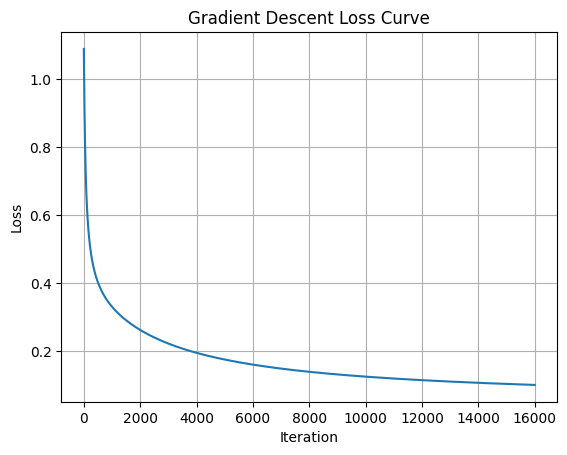

In [10]:
model = SoftmaxRegression()
model.train(x_train, Y_onehot, 0.01,max_iters=16000)

In [11]:
x_text = [5.1, 3.5, 1.4, 0.2]
model.save("multiclass.pkl")

In [20]:
infrence = SoftmaxRegression.Loader("multiclass.pkl")
infrence.predict(x_text, classes)

['setosa']